In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

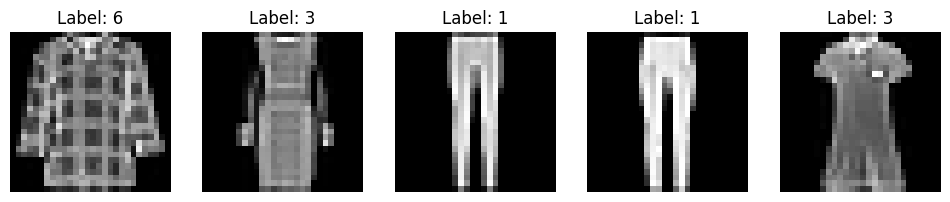

In [3]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Denormalize images for visualization
images = images * 0.5 + 0.5  # Undo normalization ([-1, 1] -> [0, 1])

# Display some images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for idx, ax in enumerate(axes):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[idx]}")
    ax.axis('off')
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [5]:
def train_model(net, num_epochs=8, learning_rate=0.05):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data

            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()

        print(f'Epoch [{epoch + 1} training accuracy: {train_correct / len(train_loader): .2f}% {train_loss / len(train_loader): .4f}]')

        val_loss = 0.0
        val_correct = 0
        net.eval()
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
        print(f'Epoch [{epoch + 1} validation accuracy: {val_correct / len(test_loader): .2f}% {val_loss / len(test_loader): .4f}]')

In [6]:
train_model(net)

Epoch [1 training accuracy:  6.98%  1.5833]
Epoch [1 validation accuracy:  2.91%  2.1735]
Epoch [2 training accuracy:  1.71%  2.2941]
Epoch [2 validation accuracy:  1.60%  2.3185]
Epoch [3 training accuracy:  1.59%  2.3097]
Epoch [3 validation accuracy:  1.60%  2.3194]
Epoch [4 training accuracy:  1.58%  2.3099]
Epoch [4 validation accuracy:  1.60%  2.3076]
Epoch [5 training accuracy:  1.61%  2.3095]
Epoch [5 validation accuracy:  1.60%  2.3065]
Epoch [6 training accuracy:  1.59%  2.3094]
Epoch [6 validation accuracy:  1.60%  2.3090]
Epoch [7 training accuracy:  1.62%  2.3099]
Epoch [7 validation accuracy:  1.60%  2.3069]
Epoch [8 training accuracy:  1.58%  2.3099]
Epoch [8 validation accuracy:  1.60%  2.3070]


In [7]:
print(next(net.parameters()).device)

cuda:0
